# **Importações e leitura**

In [99]:
# Importações

import numpy as np
import pandas as pd

import json

import nltk
from nltk.corpus import stopwords

from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

In [100]:
# Leitura dos dados

df_dataset = pd.read_csv('20052021.csv')

display(df_dataset.shape)
display(df_dataset.head())

(738, 7)

,_id,created_at,tweet_content,keyword,user_location,entities,classification
0,ObjectId(6091f3547ef2d107a44055cc),2021-05-04 12:30:48,mds nubank nunca libera mais limite pra mim,['Nubank'],Goiânia,"{'hashtags': [], 'urls': [], 'user_mentions': ...","[{""classification"":false,""created_at"":""2021-05..."
1,ObjectId(6091f3547ef2d107a44055cd),2021-05-04 12:31:09,mais viciado que a bateria do meu celular só e...,['Coca-cola'],Balneário Camboriú,"{'hashtags': [], 'urls': [], 'user_mentions': ...","[{""classification"":false,""created_at"":""2021-05..."
2,ObjectId(6091f3547ef2d107a44055ce),2021-05-04 12:31:27,toda vez que vejo Nubank nos tt vou lá conferi...,['Nubank'],None,"{'hashtags': [], 'urls': [], 'user_mentions': ...","[{""classification"":false,""created_at"":""2021-05..."
3,ObjectId(6091f3547ef2d107a44055cf),2021-05-04 12:31:25,Pedi 10k de limite pra Nubank serasi?,['Nubank'],"Rio de Janeiro, Brasil","{'hashtags': [], 'urls': [], 'user_mentions': ...","[{""classification"":true,""created_at"":""2021-05-..."
4,ObjectId(6091f3547ef2d107a44055d0),2021-05-04 12:31:20,@kayofeer @nubank Aconteceu isso c a minha mãe...,['Nubank'],"Macaé, Brasil","{'hashtags': [], 'urls': [], 'user_mentions': ...","[{""classification"":false,""created_at"":""2021-05..."


## **Engenharia de atributos**

In [101]:
# Verificação de valores nulos

display(df_dataset.isna().sum())
# display(df_dataset[df_dataset.isnull().any(axis=1)])

_id                0
created_at         0
tweet_content      0
keyword            0
user_location      1
entities           0
classification    72
dtype: int64

**Como existem 72 ocasiões cujos campos de classificação estão vazios, será feita a remoção desses registros**

In [102]:
# Remoção de atributos irrelevantes para a análise

df_removed = df_dataset.drop(['_id', 'created_at', 'user_location', 'entities'], axis=1)

display(df_removed.shape)
display(df_removed.head(n=2))

(738, 3)

,tweet_content,keyword,classification
0,mds nubank nunca libera mais limite pra mim,['Nubank'],"[{""classification"":false,""created_at"":""2021-05..."
1,mais viciado que a bateria do meu celular só e...,['Coca-cola'],"[{""classification"":false,""created_at"":""2021-05..."


In [103]:
# Remoção de amostras onde o campo de classifificação é vazio

df_dropna = df_removed.dropna(subset = ['classification'])

display(df_removed.shape)
display(df_dropna.shape)

(738, 3)

(666, 3)

### **Análise de keywords**

In [104]:
# Valores

display(Counter(df_dataset["keyword"]))

Counter({"['Nubank']": 236,
         "['Coca-cola']": 16,
         "['Nike']": 201,
         "['Xiaomi']": 26,
         "['Coca cola']": 64,
         "['SHEIN']": 169,
         '[]': 16,
         "['Boticário']": 8,
         "['Nike', 'SHEIN']": 1,
         "['Nike', 'Xiaomi']": 1})

In [105]:
# Outro modo para gerar o mesmo gráfico

# plt.hist(df_dataset["keyword"].values, bins=20, color='red', edgecolor='black', linewidth=0.9)
# plt.xticks(rotation=90)
# plt.show()

**Como existem 2 grafias distintas para "Coca-cola", será feita uma normalização desses valores**

Counter({"['Nubank']": 221,
         "['Coca-cola']": 71,
         "['Nike']": 177,
         "['Xiaomi']": 23,
         "['SHEIN']": 150,
         '[]': 15,
         "['Boticário']": 7,
         "['Nike', 'SHEIN']": 1,
         "['Nike', 'Xiaomi']": 1})

<AxesSubplot:xlabel='count', ylabel='keyword'>

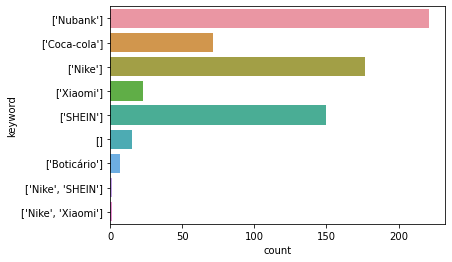

In [106]:
# Normalização de "Coca-Cola"

search = "Coca cola"
replacement = "Coca-cola"

df_normalized = df_dropna.copy()
df_normalized["keyword"] = df_dropna["keyword"].apply(
    lambda keywords: keywords.lower().replace(search.lower(), replacement) if search.lower() in keywords.lower() else keywords)


# Valores

display(Counter(df_normalized["keyword"]))


# Histograma

sns.countplot(y="keyword", data=df_normalized)

#### Testes de Counter

In [107]:
# c = Counter([True, False, False, True, True]).most_common()[0][0]
# print(c)

In [108]:
# from collections import Counter

# def reducer(item):
#   return item['classification']

# result = list(map(reducer, [
#   {'classification': True, 'created_at': 0 },
#   {'classification': False, 'created_at': 0 },
#   {'classification': True, 'created_at': 0 },
# ]))

# result_counter = Counter(result).most_common()[0][0]
# print(result_counter)

In [109]:
# test_list = [
#   {'classification': True, 'created_at': 0 },
#   {'classification': False, 'created_at': 0 },
#   {'classification': True, 'created_at': 0 },
# ]

# def get_classification(myList):
#   print('input_list', myList, type(myList))
#   return Counter(list(map(lambda item: item['classification'], myList))).most_common()[0][0]

# print(get_classification(test_list))

In [110]:
# import json

# data = json.loads('[{"classification": true, "created_at": 0 },{"classification": false, "created_at": 0 },{"classification": true, "created_at": 0 }]')
# print(type(data), data)

## **Tratamento da classificação**

Como são 3 classificações para cada registro, ganha a classificação da **maioria** dos registros

Exemplos:

- True, True, False => True
- False, True, False => False

In [111]:
# Criação de um campo de resultado de classificação com a maior ocorrência entre as classificaçações

pd.options.mode.chained_assignment = None

def reducer(input_dict):
  return input_dict['classification']

def get_classification(input_list):
  return Counter(list(map(reducer, json.loads(input_list)))).most_common()[0][0]

# df_classified = df_normalized.apply(lambda item: get_classification(item[2]), axis=1)

df_normalized['classified'] = df_normalized['classification'].map(lambda classification_list: get_classification(classification_list))

df_classified = df_normalized.drop(['classification'], axis=1)

In [112]:
# Transformação numérica da classificação

df_classified['classified'][df_classified['classified'] == True] = 1
df_classified['classified'][df_classified['classified'] == False] = 0

display(df_classified.head())

,tweet_content,keyword,classified
0,mds nubank nunca libera mais limite pra mim,['Nubank'],0.0
1,mais viciado que a bateria do meu celular só e...,['Coca-cola'],1.0
2,toda vez que vejo Nubank nos tt vou lá conferi...,['Nubank'],0.0
3,Pedi 10k de limite pra Nubank serasi?,['Nubank'],1.0
4,@kayofeer @nubank Aconteceu isso c a minha mãe...,['Nubank'],1.0


## **Pré-processamento**

1. Tokenização
2. Remoção de stopwords

### 1. Tokenização

In [113]:
# # Tokenização

# import nltk
# nltk.download('punkt', quiet=True)

# df_tokens = pd.DataFrame(df_classified['tweet_content'].apply(lambda column: nltk.word_tokenize(column)))
# # df_tokens = pd.DataFrame(df_classified.apply(lambda item: 'a' if item.name == 'classified' else item))

# display(df_tokens.head())

### 2. Remoção de stopwords

In [114]:
# Remoção de stopwords

nltk.download('stopwords', quiet=True)

stop = stopwords.words('portuguese')

df_removed_stopwords = df_classified.copy()
df_removed_stopwords['tweet_content'] = df_classified['tweet_content'].apply(lambda tweet: [word for word in tweet.split() if word not in stop])

display(df_removed_stopwords.head())

,tweet_content,keyword,classified
0,"[mds, nubank, nunca, libera, limite, pra, mim]",['Nubank'],0.0
1,"[viciado, bateria, celular, coca-cola, 🤦🏻‍♀️🤦🏻...",['Coca-cola'],1.0
2,"[toda, vez, vejo, Nubank, tt, vou, lá, conferi...",['Nubank'],0.0
3,"[Pedi, 10k, limite, pra, Nubank, serasi?]",['Nubank'],1.0
4,"[@kayofeer, @nubank, Aconteceu, c, mãe,, quase...",['Nubank'],1.0


## **Análise de classificações**

### Geral

Counter({0.0: 306, 1.0: 360})

<AxesSubplot:xlabel='classified', ylabel='count'>

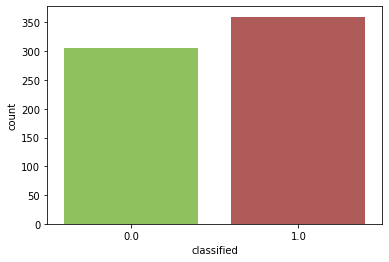

In [115]:
# Valores

display(Counter(df_removed_stopwords['classified']))


# Histograma

sns.countplot(x="classified", data=df_removed_stopwords)

### Por keywords

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


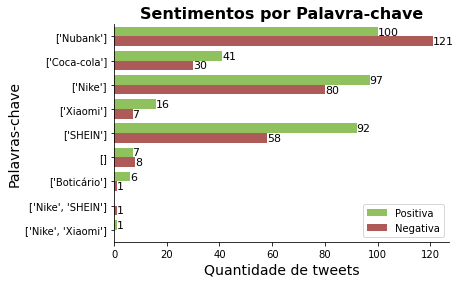

In [195]:
# Dataframe especialmente para o plot

order = ["Positiva", "Negativa"]

df_countplot = df_removed_stopwords.copy()
df_countplot = df_countplot.rename({"classified": "Classificação"}, axis=1)
df_countplot["Classificação"][df_countplot["Classificação"] == 1.0] = order[0]
df_countplot["Classificação"][df_countplot["Classificação"] == 0.0] = order[1]


# Plot

colors = ["#8FD14F", "#BC4C4B"]
sns.set_palette(sns.color_palette(colors))
plot_output = sns.countplot(y="keyword",
                            data=df_countplot,
                            hue="Classificação",
                            hue_order=order)

plot_output.legend(loc="lower right")

plot_output.set_title("Sentimentos por Palavra-chave", fontsize=16, fontweight="bold")
plot_output.set_xlabel("Quantidade de tweets", fontsize=14)
plot_output.set_ylabel("Palavras-chave", fontsize=14)

plot_output.spines["top"].set_visible(False)
plot_output.spines["right"].set_visible(False)

for rect in plot_output.patches:
    plot_output.text(rect.get_width(),
                     rect.get_y(),
                     str(rect.get_width())[:-2],
                     horizontalalignment="left",
                     verticalalignment="top",
                     fontsize=11)

plot_output.figure.savefig("keyword_analysis_labeled.png", bbox_inches="tight")